# Combine calibrated dark images for use in later reduction steps


The final step is to combine the individual calibrated dark images into a single
combined image. That combined image will have less noise than the individual
images, minimizing the noise added to the remaining images when the dark is
subtracted.

Regardless of which path you took through the calibration of the biases (with
overscan or without) there should be a folder named either `example1-reduced` or
`example2-reduced` that contains the calibrated bias and dark images. If there
is not, please run the previous notebook before continuing with this one.

In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

## Recommended settings for image combination

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/200/files#diff-3d1bd0a69f50517e257452b5fa08c685R58){:target="_blank"}

As discussed in the [notebook about combining images](01-06-Image-combination.html), the recommendation is
that you combine by averaging the individual images but sigma clip to remove
extreme values.

[ccdproc](https://ccdproc.readthedocs.org) provides two ways to combine:

+ An object-oriented interface built around the `Combiner` object, described in
the [ccdproc documentation on image combination](https://ccdproc.readthedocs.io/en/latest/image_combination.html).
+ A function called [`combine`](https://ccdproc.readthedocs.io/en/latest/api/ccdproc.combine.html#ccdproc.combine), which we will use here because the function
allows you to specify the maximum amount of memory that should be used during
combination. That feature can be essential depending on how many images you need
to combine, how big they are, and how much memory your computer has.

*NOTE: If using a version of ccdproc lower than 2.0, set the memory limit a
factor of 2-3 lower than you want the maximum memory consumption to be.*

## Example 1: Cryogenically-cooled camera

The remainder of this section assumes that the calibrated bias images are in the
folder `example1-reduced` which was created in the previous notebook.

In [3]:
calibrated_path = Path('example1-reduced')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

### Make a combined image for each exposure time in Example 1

There are several dark exposure times in this data set. By converting the times
in the summary table to a set it returns only the unique values.

In [4]:
darks = reduced_images.summary['imagetyp'] == 'DARK'
dark_times = set(reduced_images.summary['exptime'][darks])
print(dark_times)

{300.0, 70.0, 7.0}


The code below loops over the dark exposure times and, for each exposure time:

+ selects the relevant calibrated dark images,
+ combines them using the `combine` function,
+ adds the keyword `COMBINED` to the header so that later calibration steps can
easily identify which bias to use, and
+ writes the file whose name includes the exposure time.

In [5]:
for exp_time in sorted(dark_times):
    calibrated_darks = reduced_images.files_filtered(imagetyp='dark', exptime=exp_time,
                                                     include_path=True)

    combined_dark = ccdp.combine(calibrated_darks,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    combined_dark.meta['combined'] = True

    dark_file_name = 'combined_dark_{:6.3f}.fit'.format(exp_time)
    combined_dark.write(calibrated_path / dark_file_name)

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


### Result for Example 1

A single calibrated 300 second dark image and the combined 300 second image are
shown below.

Text(0.5, 1.0, '3 dark images combined')

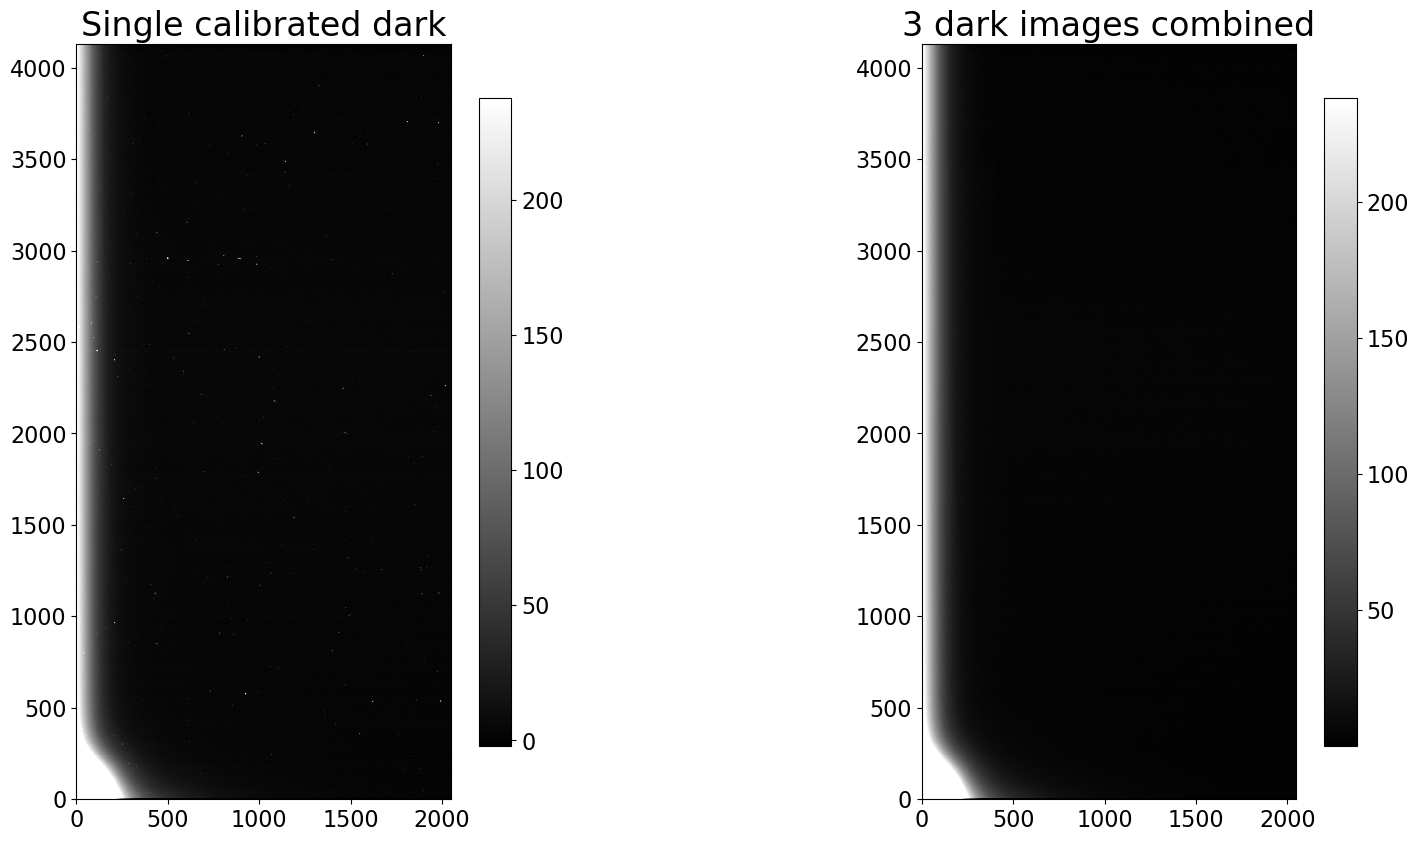

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(CCDData.read(calibrated_darks[0]).data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Single calibrated dark')
show_image(combined_dark.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('{} dark images combined'.format(len(calibrated_darks)))

## Example 2: Thermoelectrically-cooled camera

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/200/files#diff-3d1bd0a69f50517e257452b5fa08c685R197){:target="_blank"}

The process for combining the images is exactly the same as in example 1. The
only difference is the directory that contains the calibrated bias frames.

In [7]:
calibrated_path = Path('example2-reduced')
reduced_images = ccdp.ImageFileCollection(calibrated_path)

### Make a combined image for each exposure time in Example 2

In this example there are only darks of a single exposure time.

In [8]:
darks = reduced_images.summary['imagetyp'] == 'DARK'
dark_times = set(reduced_images.summary['exptime'][darks])
print(dark_times)

{90.0}


Despite the fact that there is only one exposure time, we might as well reuse
the code from above.

In [9]:
for exp_time in sorted(dark_times):
    calibrated_darks = reduced_images.files_filtered(imagetyp='dark', exptime=exp_time,
                                                     include_path=True)

    combined_dark = ccdp.combine(calibrated_darks,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    combined_dark.meta['combined'] = True

    dark_file_name = 'combined_dark_{:6.3f}.fit'.format(exp_time)
    combined_dark.write(calibrated_path / dark_file_name)

INFO:astropy:splitting each image into 12 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 12 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


### Result for Example 2

The difference between a single calibrated bias image and the combined bias
image is much clearer in this case.

Text(0.5, 1.0, '10 dark images combined')

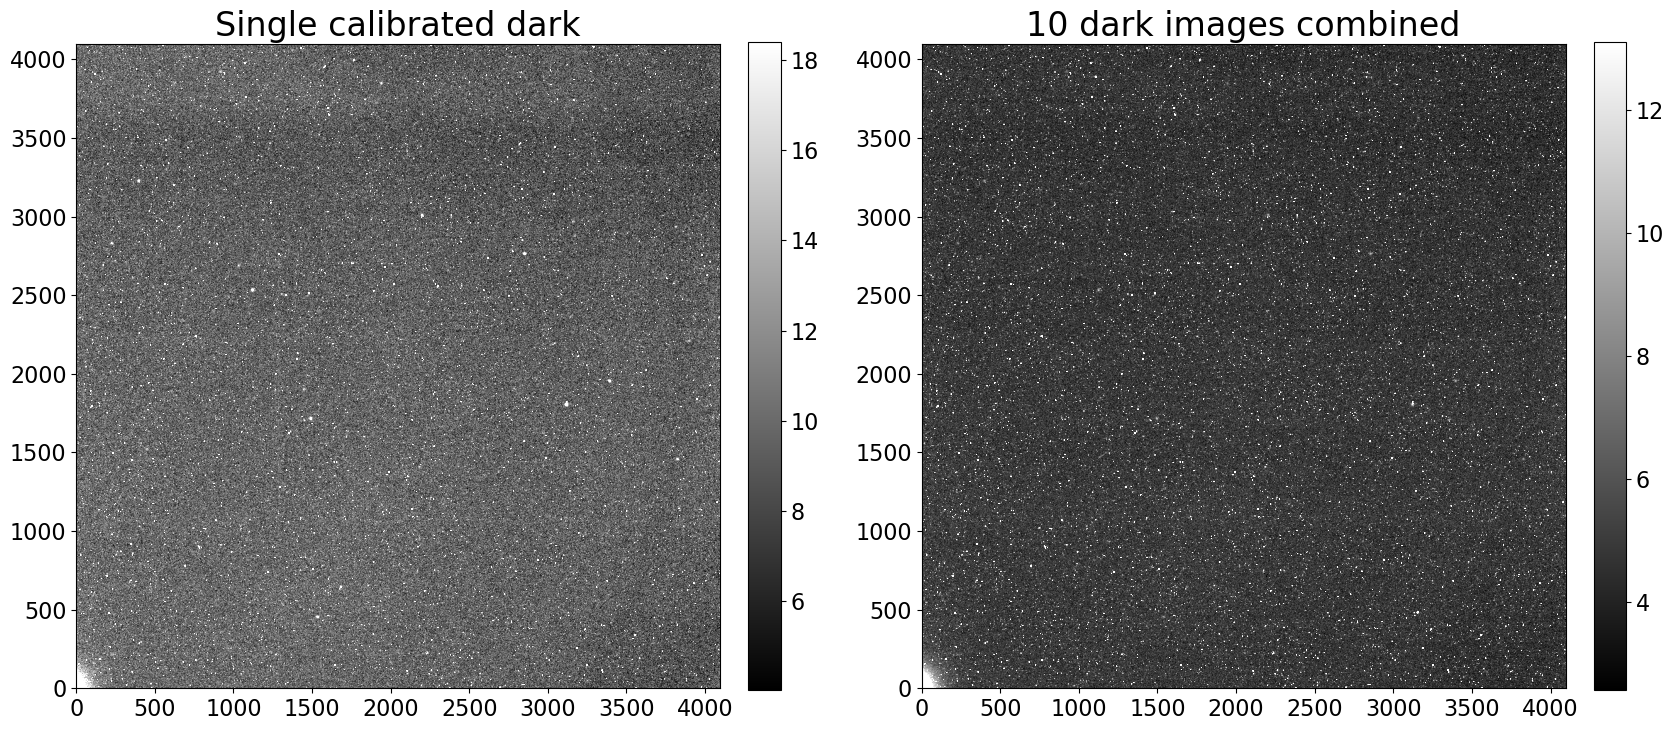

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(CCDData.read(calibrated_darks[0]).data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Single calibrated dark')
show_image(combined_dark.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('{} dark images combined'.format(len(calibrated_darks)))